# Setup

In [1]:
# !pip install tweepy
# basic tweepy setup
import tweepy
consumer_key="BQn1nUJgENsX6dZEpGTwV3v8V"
consumer_key_secret="RYjJTGnm0r6Jrypl3SwaGuQIJMhyk6zboq4vxDAWChJU9p4L87"
access_token="1226465414819065856-k4LQY3zCPXd8iFZrK0QgfdOVtF6U6S"
access_token_secret="fxPd0TIlu3g6iM3JGDHgKIFpjNiuUnoSOyaELjtQUk928"

auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth) 

In [2]:
# !pip install pymongo
# basic setup of database connection and parameters for future interaction with twitter API
from tweepy.streaming import StreamListener
import pymongo
from pymongo import MongoClient
import pprint
language="en"
keywords = ['super tuesday', 'bernie', 'warren', 'trump', 'biden', 'buttigieg', 'bloomberg', 'klobuchar', 'sanders', 'democratic', 'primary']
client = MongoClient()
db = client.twitter_data
print(db)
tweets = db.tweets

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'twitter_data')


In [316]:
#listener class for the stream api
import json
class MongoListener(StreamListener):
    def __init__(self):
        self.duplicates = 0
    def on_data(self, data):
        data_json = json.loads(data)
        if "id" in data_json.keys():
            data_json["_id"] = data_json.pop("id")
            try:
                tweets.insert_one(data_json)
            except pymongo.errors.DuplicateKeyError:
                self.duplicates+=1
        return True

    def on_error(self, status):
        print(status)

# Data retrieval

In [3]:
# Using the stream api to retreive live stream data filtering for the keywords and language
# Interrupt the cell when you retrieve satisfactory amount of data
def filter_stream(keywords):
    mongo_listener = MongoListener()
    stream = tweepy.Stream(auth = api.auth, listener=mongo_listener, tweet_mode="extended")
    stream.filter(track=keywords, languages=[language])


In [4]:
#Using REST api to retreive search results for selected keywords and language
def search_keywords(keywords):
    """Performs an API search request for 100 tweets of each keyword given and adds them to the mongo-db"""
    duplicates = 0
    for keyword in keywords:
        print('Searching for keyword {}'.format(keyword))
        search_results = api.search(q=keyword, count=100, lang=language, tweet_mode="extended")
        for result in search_results:
            json_result = result._json
            json_result["_id"] = json_result.pop("id")
            try:
                tweets.insert_one(json_result)
            except pymongo.errors.DuplicateKeyError:
                duplicates+=1
                continue
    print("Number of duplicates: {}".format(duplicates))
    
def search_users(users):
    """Performs an API timeline request for the most recent 20 tweets of each user given and adds them to the mongo-db"""
    duplicates = 0
    for user in users:
        print("Fetching user {}".format(user))
        search_results = api.user_timeline(screen_name=user, count=20, tweet_mode="extended")
        for result in search_results:
            json_result = result._json
            json_result["_id"] = json_result.pop("id")
            try:
                tweets.insert_one(json_result)
            except pymongo.errors.DuplicateKeyError:
                duplicates+=1
                continue
    print("Number of duplicates in total: {}".format(duplicates))

# Data analysis

### K-means clustering

In [5]:
#Tokenizer and normalizer using spacy
# !pip install spacy
import spacy
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['ner'])

# nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

def spacy_tokenize(string):
    tokens = []
    doc = nlp(string)
    for token in doc:
        tokens.append(token)
    return tokens

def normalize(tokens):
    normalized_tokens = []
    for token in tokens:
        normalized = token.text.lower().strip()
        if ((token.is_alpha or token.is_digit)):
            normalized_tokens.append(normalized)
    return normalized_tokens

def tokenize_normalize(string):
    return normalize(spacy_tokenize(string))

In [6]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import itertools

def fetch_tweets(retweets=False):
    client = MongoClient()
    db = client.twitter_data
    print("Connected to: ", db, '\n')
    tweets = db.tweets
    tweets_tmp = []
    if retweets:
        query={}
    else:
        query = {"retweeted_status":None}
    for tweet in tweets.find(query):
        if tweet.get("retweeted_status", False):
            tweets_tmp.append([tweet["_id"], tweet.get("retweeted_status").get("extended_tweet", tweet).get("full_text", tweet.get("text")), tweet["entities"], tweet.get("in_reply_to_screen_name", None), tweet["user"], tweet.get("user_mentions", None), tweet.get("retweeted_status")])
        else:
            tweets_tmp.append([tweet["_id"], tweet.get("extended_tweet", tweet).get("full_text", tweet.get("text")), tweet["entities"], tweet.get("in_reply_to_screen_name", None), tweet["user"], tweet.get("user_mentions", None), None])
    tweet_frame = pd.DataFrame(tweets_tmp, columns = ["id", "text", "entities", "in_reply_to_screen_name", "user", "user_mentions", "retweet_status"])
    if retweets:
        print("Retrieved {} tweets including retweets.".format(tweet_frame.shape[0]))
    else:
        print("Retrieved {} tweets without retweets.".format(tweet_frame.shape[0]))
    return tweet_frame
tweet_frame = fetch_tweets()


Connected to:  Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'twitter_data') 

Retrieved 2793 tweets without retweets.


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# setup for clustering, keys allow me to retrieve the tweets back after clustering
num_clusters = 10
tweet_vals = tweet_frame["text"].tolist()
tweet_keys = tweet_frame["id"].tolist()

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, tokenizer=tokenize_normalize, ngram_range=(1,2), max_features=50000)
tfidf_vectorizer.fit(tweet_vals)
tfidf_document_term_matrix = tfidf_vectorizer.transform(tweet_vals)
vectorizer = tfidf_vectorizer

In [8]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=4, verbose=10, init_size=10000).fit(tfidf_document_term_matrix)

Init 1/4 with method: k-means++
Inertia for init 1/4: 2719.540341
Init 2/4 with method: k-means++
Inertia for init 2/4: 2724.819903
Init 3/4 with method: k-means++
Inertia for init 3/4: 2718.420584
Init 4/4 with method: k-means++
Inertia for init 4/4: 2728.448062
Minibatch iteration 1/2800: mean batch inertia: 0.972820, ewa inertia: 0.972820 
Minibatch iteration 2/2800: mean batch inertia: 0.975166, ewa inertia: 0.972988 
Minibatch iteration 3/2800: mean batch inertia: 0.976860, ewa inertia: 0.973265 
Minibatch iteration 4/2800: mean batch inertia: 0.984594, ewa inertia: 0.974076 
Minibatch iteration 5/2800: mean batch inertia: 0.976638, ewa inertia: 0.974260 
Minibatch iteration 6/2800: mean batch inertia: 0.981931, ewa inertia: 0.974809 
Minibatch iteration 7/2800: mean batch inertia: 0.983350, ewa inertia: 0.975420 
Minibatch iteration 8/2800: mean batch inertia: 0.980517, ewa inertia: 0.975785 
Minibatch iteration 9/2800: mean batch inertia: 0.981067, ewa inertia: 0.976163 
Minibat

In [326]:
import collections

query_keywords = set()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
# print clusters and their defining words
for i in range(num_clusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        query_keywords.add(terms[ind])
        print(' %s' % terms[ind])
    print()
    
# get rid of a few common words
common_words = ['the', 'is', 'of', 'he', 'she', 'a', 'i', 'to', 'be', 'in', 'it', 'not', 'has', 'are']
for word in common_words:
    query_keywords.remove(word)
    
# <--- SEARCH FOR KEYWORDS EXTRACTED FROM THE STREAMING DATA HERE --->
# Note that this is slow, limited to a small number of tweets and devalues the data
# search_keywords(query_keywords)
# <--- SEARCH FOR KEYWORDS EXTRACTED FROM THE STREAMING DATA HERE --->

# Group the posts by their cluster labels.
clustering = collections.defaultdict(list)
for idx, label in enumerate(kmeans.labels_):
    clustering[label].append(idx)
for cluster, indices in clustering.items():
    print("\nCluster:", cluster, " Num posts: ", len(indices))
    cur_docs = 0
    for index in indices:
        if (cur_docs > 10):
            break
        if index < len(tweet_vals):
            tweet_contents = tweet_vals[index].replace('\n', '')
            print(index, tweet_keys[index], (tweet_contents[:75] + '..') if len(tweet_contents) > 75 else tweet_contents)
        else:
            print("Index {} outside of length of tweet_vals {}, len of tweet_keys is {}".format(index, len(tweet_vals), len(tweet_keys)))
        cur_docs+=1
        
largest_cluster = max(clustering.items(), key=lambda x : len(x[1]))
print('\nLargest cluster found with lenght {} '.format(len(largest_cluster)))
tweet_frame_cluster = tweet_frame.iloc[largest_cluster[1]]
cluster_ids = list(tweet_frame_cluster["id"])


Cluster 0:
 party
 democratic
 warped and
 warped
 and delusional
 the democratic
 delusional
 democratic party
 the
 primary

Cluster 1:
 trump
 2020
 your
 trump 2020
 you
 thank
 trump and
 thank you
 president trump
 president

Cluster 2:
 the
 in
 a
 of
 for
 this
 to
 i
 in the
 trump

Cluster 3:
 warren
 vote
 for
 vote for
 she
 elizabeth
 elizabeth warren
 to
 the
 so

Cluster 4:
 what
 you
 are
 exactly
 is
 trump
 the
 posted
 what a
 that

Cluster 5:
 would
 he
 social security
 biden
 security
 social
 joe biden
 joe
 promised
 trump

Cluster 6:
 the
 is
 a
 and
 to
 of
 trump
 has
 that
 for

Cluster 7:
 sanders
 bernie sanders
 bernie
 get
 to
 flavor
 flavor flav
 flav
 a
 to get

Cluster 8:
 to
 the
 i
 it
 not
 is
 trump
 and
 a
 be

Cluster 9:
 tomorrow
 bernie
 bernie revolution
 remember
 revolution
 bernie supporters
 to
 vote
 supporters
 to vote


Cluster: 2  Num posts:  192
0 1234543346904858625 5 Key Questions Ahead of Critical Super Tuesday Primaries - https:

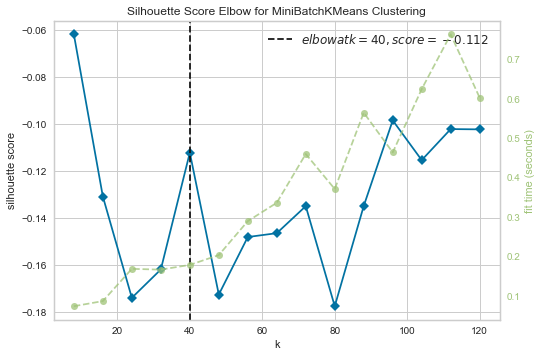

In [320]:
# elbow method to find best k for number of clusters
# !pip install yellowbrick
import numpy as np
from yellowbrick.cluster import KElbowVisualizer

# <--- FIND OPTIMAL K USING THE ELBOW METHOD, NOTE THIS IS EXTREMELY SLOW SO I LEFT IT COMMENTED --->
# model = MiniBatchKMeans(init='k-means++', n_init=3)
# visualizer = KElbowVisualizer(model, metric='silhouette', k=np.arange(1, 16)*8)
# visualizer.fit(onehot_document_term_matrix)
# visualizer.show()
# <--- FIND OPTIMAL K USING THE ELBOW METHOD, NOTE THIS IS EXTREMELY SLOW SO I LEFT IT COMMENTED --->


## Graphs
### Setup graphs from database

In [274]:
import networkx as nx
import pymongo
from pymongo import MongoClient
import pandas as pd
import itertools


retweet_graph = nx.DiGraph()
mention_graph = nx.DiGraph()
hashtag_graph = nx.Graph()
reply_graph = nx.DiGraph()

client = MongoClient()
db = client.twitter_data_full
print(db, '\n')
tweets = db.tweets

# build all the graphs from the tweet data, ignore retweets for non-retweet graphs 
for tweet in tweets.find():
# for  tweet in tweets.find({ "_id" : { "$in" : cluster_ids } }):
    username = tweet.get("user").get("screen_name")
    if tweet.get("retweeted_status"):
        retweet_username = tweet.get("retweeted_status").get("user").get("screen_name")
        if retweet_graph.has_node(username):
            retweet_graph.nodes[username]["retweets"]+=1
        else:
            retweet_graph.add_node(username, retweeted = 0, retweets=1)
        if retweet_graph.has_node(retweet_username):
            retweet_graph.nodes[retweet_username]["retweeted"] += 1
        else:
            retweet_graph.add_node(retweet_username, retweeted = 1, retweets=0)
        if retweet_graph.has_edge(username, retweet_username):
            retweet_graph[username][retweet_username]["weight"] += 1
        else:
            retweet_graph.add_edge(username, retweet_username, weight=1)
    else:
        if tweet.get("in_reply_to_screen_name"):
            reply_username = tweet.get("in_reply_to_screen_name")
            if reply_graph.has_node(username):
                reply_graph.nodes[username]["replied"]+=1
            else:
                reply_graph.add_node(username, replied_to = 0, replied=1)
            if reply_graph.has_node(reply_username):
                reply_graph.nodes[reply_username]["replied_to"] += 1
            else:
                reply_graph.add_node(reply_username, replied_to = 1, replied=0)
            if reply_graph.has_edge(username, reply_username):
                reply_graph[username][reply_username]["weight"] += 1
            else:
                reply_graph.add_edge(username, reply_username, weight=1)
            
        hashtags = tweet.get("entities").get("hashtags")
        if hashtags != []:
            for hashtag in hashtags:
                if hashtag_graph.has_node(hashtag.get("text")):
                    hashtag_graph.nodes[hashtag.get("text")]["uses"]+=1
                else:
                    hashtag_graph.add_node(hashtag.get("text"), uses=1, label=hashtag.get("text"))
        if len(hashtags) > 2:
            for i in range(len(hashtags)-1):
                for j in range(i+1, len(hashtags)):
                    if hashtag_graph.has_edge(hashtags[i].get("text"), hashtags[j].get("text")):
                        hashtag_graph[hashtags[i].get("text")][hashtags[j].get("text")]["weight"] += 1
                    else:
                        hashtag_graph.add_edge(hashtags[i].get("text"), hashtags[j].get("text"), weight=1)
        mentions = tweet.get("entities").get("user_mentions")
        if len(hashtags) != []:
            for user in mentions:
                mention_name = user.get("screen_name")
                if mention_graph.has_node(username):
                    mention_graph.nodes[username]["mentions"]+=1
                else:
                    mention_graph.add_node(username, mentioned = 0, mentions=1)
                if mention_graph.has_node(mention_name):
                    mention_graph.nodes[mention_name]["mentioned"] += 1
                else:
                    mention_graph.add_node(mention_name, mentioned = 1, mentions=0)
                if mention_graph.has_edge(username, mention_name):
                    mention_graph[username][mention_name]["weight"] += 1
                else:
                    mention_graph.add_edge(username, mention_name, weight=1)
print("Finished building graphs.")

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'twitter_data_full') 

Finished building graphs.


## Plot hashtag graph - note this is slow for big datasets


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
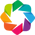

:Nodes   [x,y,index]   (label,uses)


:Overlay
   .Graph.I  :Graph   [start,end]   (weight)
   .Labels.I :Labels   [x,y]   (label)

In [286]:
# !pip install holoviews
# !pip install scikit-image
# !pip install xarray
# !pip install datashader
import matplotlib.pyplot as plt
import networkx.drawing
import holoviews as hv
import copy
from holoviews import opts
from holoviews.operation.datashader import datashade, bundle_graph
use_limit = 2


limited_hashtags = hashtag_graph
nodes = copy.deepcopy(limited_hashtags.nodes())
for node in nodes:
    if limited_hashtags.nodes[node]['uses'] < use_limit:
        limited_hashtags.remove_node(node)
        
hv.extension('bokeh')
defaults = dict(width=800, height=800, padding=0.1)
hv.opts.defaults(
    opts.EdgePaths(**defaults), opts.Graph(**defaults), opts.Nodes(**defaults))
visualisation = hv.Graph.from_networkx(limited_hashtags, nx.fruchterman_reingold_layout, k=1)
visualisation.opts(cmap='Inferno_r', edge_cmap='Cividis_r', node_size=10, edge_color='weight', node_color='uses')

print(visualisation.nodes[0])

bundled = bundle_graph(visualisation)


labels = hv.Labels(visualisation.nodes, ['x', 'y'], 'label')
(bundled * labels.opts(text_font_size='6pt', text_color='Gray', yoffset=0.025))


## Plot mention graph - note this is slow for big datasets

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
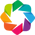

:Graph   [start,end]   (weight)

In [282]:
import matplotlib.pyplot as plt
import networkx.drawing
import holoviews as hv
import copy
from holoviews import opts
from holoviews.operation.datashader import datashade, bundle_graph
use_limit = 20
nodes = copy.deepcopy(mention_graph.nodes())
for node in nodes:
    if mention_graph.nodes[node]['mentions'] + mention_graph.nodes[node]['mentioned'] < use_limit:
        mention_graph.remove_node(node)

hv.extension('bokeh')
defaults = dict(width=800, height=800, padding=0.1)
hv.opts.defaults(
    opts.EdgePaths(**defaults), opts.Graph(**defaults), opts.Nodes(**defaults))
mention_v = hv.Graph.from_networkx(mention_graph, nx.fruchterman_reingold_layout, k=1)
mention_v.opts(cmap='Inferno_r', edge_cmap='Cividis_r', node_size=10, edge_color='weight', node_color='mentions')

mention_b = bundle_graph(mention_v)
mention_b
# (datashade(mention_b, normalization='linear', width=800, height=800) * mention_b.nodes).opts(
#     opts.Nodes(width=1000, cmap='Cividis_r'))

# labels = hv.Labels(mention_v.nodes, ['x', 'y'], 'label')
# (mention_b * labels.opts(text_font_size='6pt', text_color='Gray', yoffset=0.025))


In [279]:
nx.triadic_census(mention_graph)

{'003': 10568861319844,
 '012': 2038834198,
 '102': 49082551,
 '021D': 71377,
 '021U': 5037630,
 '021C': 15044,
 '111D': 2261,
 '111U': 2804,
 '030T': 3406,
 '030C': 0,
 '201': 208,
 '120D': 147,
 '120U': 2344,
 '120C': 5,
 '210': 82,
 '300': 119}